In [1]:
from os.path import splitext
from os import listdir
from os.path import join
import os
import numpy as np
from glob import glob
import torch
from torch.utils.data import Dataset
import logging
from PIL import Image
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import argparse

In [ ]:

def GiveImageAndTargetLists(main_path):
    #C:/Users/MSalehjahromi/Data_ICON/
    CT_list = []
    PET_list = []

    CT_path_file  = main_path + "CT_mhd_mori/"
    PET_path_file = main_path + "PET_reg_mhd_Sheeba/"

    for folder_name in os.listdir(CT_path_file):
        #print(folder_name)
        whole_path_CT = CT_path_file + folder_name +"/"
        whole_path_PET = PET_path_file + folder_name +"/"

        if os.path.isdir(whole_path_CT) & os.path.isdir(whole_path_PET):
            #print(whole_path_CT)
            CT_path  = whole_path_CT + "CT_conv.mhd"
            PET_path = whole_path_PET + "result.0.mhd"

            CT_list.append(CT_path)
            PET_list.append(PET_path)
            
    return (CT_list, PET_list)


def SavingAsNpy(CT_list, PET_list, CT_Tr_path, PET_Tr_path, CT_Ts_path, PET_Ts_path, CT_Va_path,  PET_Va_path, prefix=""):

    count_ts = 0
    count_tr = 0
    count_va = 0
    for j in range(len(CT_list)):

        #print()

        key = CT_list[j].split('/')[-2]
        start_slide, end_slide = Lung[key]
        print(j,'/',len(CT_list)-1)

        if PET_list[0].split('/')[-2] == CT_list[0].split('/')[-2]:
           
            #Save ~9% of patients data in the test files
            if j < len(CT_list)*0.09:
                print('Saving', key, 'case in Test folder ...')
                CT = sitk.ReadImage(CT_list[j])
                dst_CT_name = "CTPET_3D_"+ prefix +'_'+ str(count_ts).zfill(6) + ".nii.gz"
                dst_CT_path = os.path.join(CT_Ts_path, dst_CT_name)
                sitk.WriteImage(CT,dst_CT_path )
                
                PET = sitk.ReadImage(PET_list[j])
                dst_PET_name = "CTPET_3D_"+ prefix +'_'+ str(count_ts).zfill(6) + ".nii.gz"
                dst_PET_path = os.path.join(PET_Ts_path, dst_PET_name)
                sitk.WriteImage(PET,dst_PET_path )
                               
                count_ts += 1

            elif j < len(CT_list)*0.16:
                print( 'Saving', key, 'case in validation folder','  slides: (', start_slide,',', end_slide,')')
                CT = io.imread(CT_list[j], plugin='simpleitk') #CT = np.array(CT)   
                PET = io.imread(PET_list[j], plugin='simpleitk') #PET = np.array(PET)
                
                CT_path  = CT_Va_path
                PET_path   = PET_Va_path

                #Saving channel CT & PET images 
                for k in range(start_slide, end_slide,1):  # Removing the first and last images as they are not reliable

                    CT_k = np.array( CT[k-2:k+3,:,:] )
                    PET_k = np.array( PET[k-2:k+3,:,:] )

                    dst_img_name = "CTPET_"+ '_'+ str(count_va).zfill(6) + ".npy"
                    dst_img_path = os.path.join(CT_path, dst_img_name)
                    np.save(dst_img_path, CT_k)

                    dst_label_name = "CTPET_"+ '_'+ str(count_va).zfill(6) + ".npy"
                    dst_mask_path = os.path.join(PET_path, dst_label_name)
                    np.save(dst_mask_path, PET_k)
                
                    count_va += 1            

            elif key in Lung:
                print( 'Saving', key, 'case in train folder','  slides: (', start_slide,',', end_slide,')')
                CT = io.imread(CT_list[j], plugin='simpleitk') #CT = np.array(CT)   
                PET = io.imread(PET_list[j], plugin='simpleitk') #PET = np.array(PET)
                
                CT_path  = CT_Tr_path
                PET_path   = PET_Tr_path

                #Saving channel CT & PET images 
                for k in range(start_slide, end_slide,1):  # Removing the first and last images as they are not reliable

                    CT_k = np.array( CT[k-2:k+3,:,:] )
                    PET_k = np.array( PET[k-2:k+3,:,:] )

                    dst_img_name = "CTPET_"+ prefix +'_'+ str(count_tr).zfill(6) + ".npy"
                    dst_img_path = os.path.join(CT_path, dst_img_name)
                    np.save(dst_img_path, CT_k)

                    dst_label_name = "CTPET_"+ prefix +'_'+ str(count_tr).zfill(6) + ".npy"
                    dst_mask_path = os.path.join(PET_path, dst_label_name)
                    np.save(dst_mask_path, PET_k)
                
                    count_tr += 1
    
    return (count_ts, count_tr, count_va)


if __name__=='__main__':

    # Destination directory
    main_folder = '/Data/CTtoPET/CTPET_5ChlWithSld2_ValTrainTest_lungOnly_May5'
    os.makedirs(main_folder,exist_ok=True)
    #if os.path.exists(nnUnet_im_lbl_folder):
        #shutil.rmtree(nnUnet_im_lbl_folder)

    # Train
    CT_Tr_path = os.path.join(main_folder, "CT_Tr")
    os.makedirs(CT_Tr_path,exist_ok=True)

    PET_Tr_path = os.path.join(main_folder, "PET_Tr")
    os.makedirs(PET_Tr_path,exist_ok=True)

    # Val
    CT_Va_path = os.path.join(main_folder, "CT_Va")
    os.makedirs(CT_Va_path,exist_ok=True)

    PET_Va_path = os.path.join(main_folder, "PET_Va")
    os.makedirs(PET_Va_path,exist_ok=True)

    # Test
    CT_Ts_path = os.path.join(main_folder, "CT_Ts")
    os.makedirs(CT_Ts_path,exist_ok=True)

    PET_Ts_path = os.path.join(main_folder, "PET_Ts")
    os.makedirs(PET_Ts_path,exist_ok=True)
    

    #Getting images_list & target_list
    raw_dot_m_files = '/Data/CTtoPET/MainRaw/'
    CT_list, PET_list = GiveImageAndTargetLists(raw_dot_m_files)
    print("len(CT_list) & len(PET_list):",len(CT_list),'  &  ' ,len(PET_list))

    prefix = ""

    #Let's shuffle them
    indices = np.arange(len(CT_list))
    np.random.shuffle(indices)

    CT_list, PET_list = np.array(CT_list),  np.array(PET_list)

    CT_list = CT_list[indices]
    PET_list = PET_list[indices]

    #SavingD
    SavingAsNpy(CT_list,    PET_list,  
                CT_Tr_path,  PET_Tr_path, 
                CT_Ts_path,  PET_Ts_path,
                CT_Va_path,  PET_Va_path,
                prefix=prefix)



In [ ]:
if __name__ == "__main__":
    args = get_args()
    in_files = os.listdir(args.inputDir) 
    #out_files = get_output_filenames(args)

    if args.loadUNet =='UNet':
        net = UNet(n_channels=1, n_classes=1)
    elif args.loadUNet =='UNet_AU':
        net = UNet_AU(in_channels=5, out_channels=1)

    logging.info("Loading model {}".format(args.model))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    logging.info(f'Using device {device}')
    net.to(device=device)
    net.load_state_dict(torch.load(args.model, map_location=device))
    logging.info("Model loaded !")

    for i, fn in enumerate(in_files):
        logging.info("\nPredicting image {} ...".format(fn))

        full_fn = os.path.join(args.inputDir,fn)
        whole_img = nib.load(full_fn)
        img = whole_img.get_fdata()
        
    
        PET = np.zeros(img.shape)
            #print('Channel out of', img.shape[0]),
        
        # Going over all slices
        print(i, ') Predicting PET of   ', fn)
        for j in range(2,img.shape[2]-3):
            print(j,'/',img.shape[2],end='     ')
            PET[:,:,j] = predict_img(net=net,
                           full_img=img[:,:,j-2:j+3],                         
                           device=device)

        # Saving to NIFTI    
        os.makedirs(args.outputDir,exist_ok=True)   
        PET = (PET*args.SUVThresh*100).astype(np.int16)
        img_nifti = nib.Nifti1Image( PET, whole_img.affine )
        
        pathsplit = fn.split('.')
        out_files = ("{}_OUT.nii.gz".format(pathsplit[0]))   
        img_nifti.to_filename(os.path.join(args.outputDir,out_files))
        
        print('Saved!:' ,out_files)

In [17]:
import nibabel as nib

whole_img = nib.load('Pre_CT.nii.gz')
CT = whole_img.get_fdata()

seg = nib.load('Pre_Seg.nii.gz')
seg = seg.get_fdata()

Pre_CT = nib.load('Pre_CT_contrast.nii.gz')
Pre_CT = Pre_CT.get_fdata()
#img_NIFTI = nib.Nifti1Image(CT_new, whole_img.affine )
#img_NIFTI.to_filename('path.nii.gz')



In [18]:
CT.shape

(512, 512, 402)

In [19]:
seg.shape

(512, 512, 333)

In [20]:
Pre_CT.shape

(512, 512, 333)

161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178


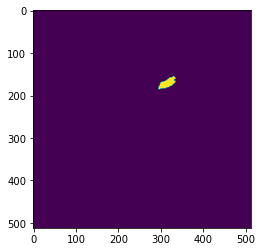

In [42]:

for k in range(seg.shape[2]):
    a = seg[:,:,k].reshape(512*512)
    #print(k , '   ', a.max())
    if a.max() != 0.0:
        print(k)
plt.imshow(seg[:,:,170])

In [22]:
np.reshape(seg[:,:,100],(512*512))

array([0., 0., 0., ..., 0., 0., 0.])

In [15]:
seg[:,:,100]

TypeError: Cannot slice image objects; consider using `img.slicer[slice]` to generate a sliced image (see documentation for caveats) or slicing image array data with `img.dataobj[slice]` or `img.get_fdata()[slice]`

In [16]:
seg.shape

(512, 512, 333)

In [25]:
a.max()

0.0

In [32]:
if seg.max() == 0:
    print('hihi')

In [39]:
if a.max != 0.0:
    print('hi')

hi


In [45]:
5%5

0